In [1]:
!pip install tonic --quiet
!pip install snntorch --quiet

In [2]:
import tonic.transforms as transforms
import tonic

sensor_size = tonic.datasets.NMNIST.sensor_size

# Denoise removes isolated, one-off events
# time_window
frame_transform = transforms.Compose([transforms.Denoise(filter_time=10000),
                                      transforms.ToFrame(sensor_size=sensor_size,
                                                         time_window=1000)
                                     ])

trainset = tonic.datasets.NMNIST(save_to='./data', transform=frame_transform, train=True)
testset = tonic.datasets.NMNIST(save_to='./data', transform=frame_transform, train=False)

In [3]:
def load_sample_simple():
    for i in range(100):
        events, target = trainset[i]

In [4]:
from torch.utils.data import DataLoader
from tonic import DiskCachedDataset


cached_trainset = DiskCachedDataset(trainset, cache_path='./cache/nmnist/train')
cached_dataloader = DataLoader(cached_trainset)

batch_size = 128
trainloader = DataLoader(cached_trainset, batch_size=batch_size, collate_fn=tonic.collation.PadTensors())

In [5]:
def load_sample_batched():
    events, target = next(iter(cached_dataloader))

In [6]:
import torch
import torchvision

transform = tonic.transforms.Compose([torch.from_numpy,
                                      torchvision.transforms.RandomRotation([-10,10])])

cached_trainset = DiskCachedDataset(trainset, transform=transform, cache_path='./cache/nmnist/train')

# no augmentations for the testset
cached_testset = DiskCachedDataset(testset, cache_path='./cache/nmnist/test')

batch_size = 128
trainloader = DataLoader(cached_trainset, batch_size=batch_size, collate_fn=tonic.collation.PadTensors(batch_first=False), shuffle=True)
testloader = DataLoader(cached_testset, batch_size=batch_size, collate_fn=tonic.collation.PadTensors(batch_first=False))

In [7]:
print(len(testloader.dataset))
print(type(testloader))

10000
<class 'torch.utils.data.dataloader.DataLoader'>


In [8]:
# import random
# from torch.utils.data import SubsetRandomSampler, DataLoader

# # Calculate the total number of images in the testloader
# total_images = len(testloader.dataset)

# # Sampling a subset of 100 images
# test_subset_indices = random.sample(range(total_images), 100)

# # Create a SubsetRandomSampler from the sampled indices
# test_subset_sampler = SubsetRandomSampler(test_subset_indices)

# # Create a DataLoader using the SubsetRandomSampler
# batch_size = 128  # You can adjust the batch size as needed
# test_subset_loader = DataLoader(testloader.dataset, batch_size=batch_size, sampler=test_subset_sampler, collate_fn=tonic.collation.PadTensors(batch_first=False))


In [12]:
# print(len(test_subset_sampler))
# print(type(test_subset_loader))

In [9]:
import snntorch as snn
from snntorch import surrogate
from snntorch import functional as SF
from snntorch import spikeplot as splt
from snntorch import utils
import torch.nn as nn

In [10]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("mps") if torch.backends.mps.is_available() else torch.device("cpu")

# neuron and simulation parameters
spike_grad = surrogate.atan()
beta = 0.5

#  Initialize Network of Convolutional Spiking Neural Network
net = nn.Sequential(nn.Conv2d(2, 12, 5),
                    nn.MaxPool2d(2),
                    snn.Leaky(beta=beta, spike_grad=spike_grad, init_hidden=True),
                    nn.Conv2d(12, 32, 5),
                    nn.MaxPool2d(2),
                    snn.Leaky(beta=beta, spike_grad=spike_grad, init_hidden=True),
                    nn.Flatten(),
                    nn.Linear(32*5*5, 10),
                    snn.Leaky(beta=beta, spike_grad=spike_grad, init_hidden=True, output=True)
                    ).to(device)

In [11]:
# this time, we won't return membrane as we don't need it

def forward_pass(net, data):
  spk_rec = []
  utils.reset(net)  # resets hidden states for all LIF neurons in net

  for step in range(data.size(0)):  # data.size(0) = number of time steps
      spk_out, mem_out = net(data[step])
      spk_rec.append(spk_out)

  return torch.stack(spk_rec)

Defining the hyperparameters and loss function

In [12]:
optimizer = torch.optim.Adam(net.parameters(), lr=2e-2, betas=(0.9, 0.999))
loss_fn = SF.mse_count_loss(correct_rate=0.8, incorrect_rate=0.2)

In [11]:
!pip install matplotlib --quiet

Training the data.

In [14]:
import matplotlib.pyplot as plt
import random

from torch.utils.data import SubsetRandomSampler, DataLoader

#Total number of images in the testloader
total_images = len(testloader.dataset)


num_epochs = 1
num_iters = 100
test_interval = 20  # Evaluate testing accuracy after every 10 iterations

loss_hist = []
train_acc_hist = []
test_acc_hist = []

# Training loop
for epoch in range(num_epochs):
    for i, (data, targets) in enumerate(iter(trainloader)):
        data = data.to(device)
        targets = targets.to(device)

        net.train()
        spk_rec = forward_pass(net, data)
        loss_val = loss_fn(spk_rec, targets)

        # Gradient calculation + weight update
        optimizer.zero_grad()
        loss_val.backward()
        optimizer.step()

        # Store loss history for future plotting
        loss_hist.append(loss_val.item())

        print(f"Epoch {epoch}, Iteration {i} \nTrain Loss: {loss_val.item():.2f}")

        acc = SF.accuracy_rate(spk_rec, targets)
        train_acc_hist.append(acc)
        print(f"Training Accuracy: {acc * 100:.2f}%\n")

        # Evaluate testing accuracy at specified intervals
        if i % test_interval == 0:
            net.eval()  # Set the model to evaluation mode
            test_acc = 0

            # Sampling a subset of 100 images
            test_subset_indices = random.sample(range(total_images), 100)

            # Create a SubsetRandomSampler from the sampled indices
            test_subset_sampler = SubsetRandomSampler(test_subset_indices)

            # Create a DataLoader using the SubsetRandomSampler to make a subset of testdata to be used for evaluation
            batch_size = 128  # You can adjust the batch size as needed
            test_subset_loader = DataLoader(testloader.dataset, batch_size=batch_size, sampler=test_subset_sampler, collate_fn=tonic.collation.PadTensors(batch_first=False))

            with torch.no_grad():  # Disable gradient computation for evaluation and updation of weights
                for data_test, targets_test in test_subset_loader:
                    data_test = data_test.to(device)
                    targets_test = targets_test.to(device)
                    spk_rec_test = forward_pass(net, data_test)
                    test_acc += SF.accuracy_rate(spk_rec_test, targets_test)

            test_acc_hist.append(test_acc)
            print(f"Testing Accuracy: {test_acc * 100:.2f}%\n")

        # Training loop breaks after num_iters iterations
        if i == num_iters:
            break



Epoch 0, Iteration 0 
Train Loss: 6.64
Training Accuracy: 73.44%

Testing Accuracy: 74.00%

Epoch 0, Iteration 1 
Train Loss: 7.08
Training Accuracy: 71.09%

Epoch 0, Iteration 2 
Train Loss: 6.43
Training Accuracy: 76.56%

Epoch 0, Iteration 3 
Train Loss: 6.77
Training Accuracy: 71.09%

Epoch 0, Iteration 4 
Train Loss: 6.55
Training Accuracy: 75.78%

Epoch 0, Iteration 5 
Train Loss: 6.63
Training Accuracy: 71.88%

Epoch 0, Iteration 6 
Train Loss: 5.96
Training Accuracy: 80.47%

Epoch 0, Iteration 7 
Train Loss: 6.43
Training Accuracy: 76.56%

Epoch 0, Iteration 8 
Train Loss: 6.65
Training Accuracy: 71.09%

Epoch 0, Iteration 9 
Train Loss: 6.29
Training Accuracy: 79.69%

Epoch 0, Iteration 10 
Train Loss: 5.62
Training Accuracy: 82.81%

Epoch 0, Iteration 11 
Train Loss: 6.04
Training Accuracy: 79.69%

Epoch 0, Iteration 12 
Train Loss: 6.08
Training Accuracy: 74.22%

Epoch 0, Iteration 13 
Train Loss: 5.68
Training Accuracy: 78.12%

Epoch 0, Iteration 14 
Train Loss: 5.82
Traini

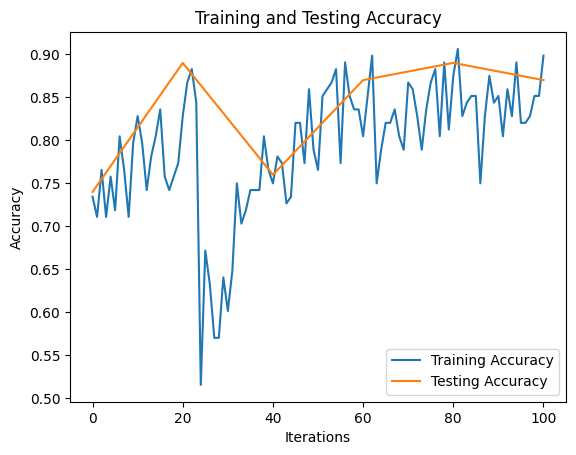

In [15]:
# Plotting accuracy history
plt.plot(range(len(train_acc_hist)), train_acc_hist, label='Training Accuracy')
plt.plot(range(0, len(test_acc_hist) * test_interval, test_interval), test_acc_hist, label='Testing Accuracy')
plt.xlabel('Iterations')
plt.ylabel('Accuracy')
plt.title('Training and Testing Accuracy')
plt.legend()
plt.show()


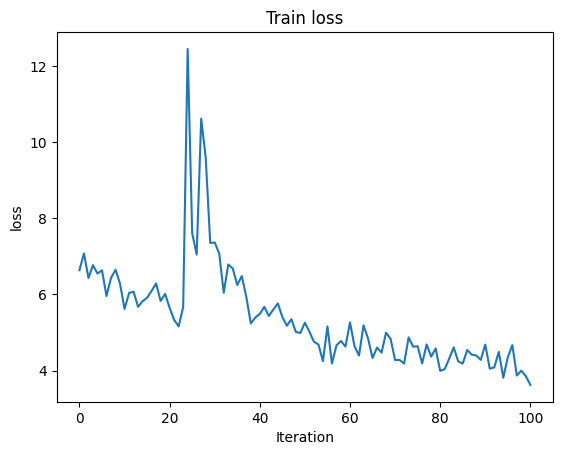

In [16]:

# Plot loss
fig = plt.figure(facecolor="w")
plt.plot(loss_hist)
plt.title("Train loss")
plt.xlabel("Iteration")
plt.ylabel("loss")
plt.show()